In [1]:
import pandas as pd

def transform_age_classes_one_hot(csv_path, output_csv):
    """
    Transforms the age column into one-hot encoded classes and maps them as follows:
    10-20 -> AGE_CLASS_0
    20-30 -> AGE_CLASS_1
    30-40 -> AGE_CLASS_2
    40-50 -> AGE_CLASS_3
    50+   -> AGE_CLASS_4

    Parameters:
    - csv_path (str): The path to the input CSV file.
    - output_csv (str): The path to save the transformed CSV file.
    """
    # Load the CSV file into a pandas DataFrame
    df = pd.read_csv(csv_path)

    # Define the bins and corresponding labels (age classes)
    bins = [10, 20, 30, 40, 50, float('inf')]  # float('inf') is used to cover ages greater than 50
    labels = [0, 1, 2, 3, 4]  # New labels for the classes

    # Create a new column 'AGE_CLASS' based on the age bins
    df['AGE_CLASS'] = pd.cut(df['AGE'], bins=bins, labels=labels, right=False)

    # Drop rows where the AGE column is not in the defined range (i.e., NaN in AGE_CLASS)
    df = df.dropna(subset=['AGE_CLASS'])

    # Convert AGE_CLASS to integer type (as cut returns category type)
    df['AGE_CLASS'] = df['AGE_CLASS'].astype(int)

    # One-hot encode the AGE_CLASS column
    one_hot_encoded_df = pd.get_dummies(df, columns=['AGE_CLASS'], prefix='AGE_CLASS')

    # Save the one-hot encoded DataFrame to a new CSV file
    one_hot_encoded_df.to_csv(output_csv, index=False)

    print(f"Transformed data with one-hot encoded age classes saved to {output_csv}")

# Example usage:
csv_path = 'demographics_csv/demo_keystroke.csv'  # Your input CSV path
output_csv = 'demographics_csv/age_one_hot_all.csv'  # Output CSV path

transform_age_classes_one_hot(csv_path, output_csv)


C:\Users\dekassla\AppData\Local\Temp\ipykernel_21520\3624466757.py:44: DtypeWarning: Columns (41) have mixed types.Specify dtype option on import or set low_memory=False.
  transform_age_classes_one_hot(csv_path, output_csv)
D:\Coding_Projects\erkd\.venv\lib\site-packages\pandas\core\arrays\categorical.py:528: RuntimeWarning: invalid value encountered in cast
  fill_value = lib.item_from_zerodim(np.array(np.nan).astype(dtype))


Transformed data with one-hot encoded age classes saved to demographics_csv/age_one_hot_all.csv


In [2]:
import pandas as pd

# Load the CSV file into a pandas DataFrame
csv_path = 'demographics_csv/age_one_hot_all.csv'  # Replace with your actual CSV file path
df = pd.read_csv(csv_path)

# Display the first 5 rows of the DataFrame
print(df.head())


   PARTICIPANT_ID  AGE  GENDER  HAS_TAKEN_TYPING_COURSE COUNTRY  LAYOUT  \
0            1002   31  female                        0      PH  qwerty   
1            1002   31  female                        0      PH  qwerty   
2            1002   31  female                        0      PH  qwerty   
3            1002   31  female                        0      PH  qwerty   
4            1002   31  female                        0      PH  qwerty   

  NATIVE_LANGUAGE FINGERS  TIME_SPENT_TYPING KEYBOARD_TYPE  ...  \
0              en    9-10                  2        laptop  ...   
1              en    9-10                  2        laptop  ...   
2              en    9-10                  2        laptop  ...   
3              en    9-10                  2        laptop  ...   
4              en    9-10                  2        laptop  ...   

   KEY_HOLD_TIME_STD  ERROR_RATE_y  CONSECUTIVE_KEYS  CONSECUTIVE_KEYS_TIME  \
0       1.248468e+07      0.054323            1684.0              -

D:\Coding_Projects\erkd\.venv\lib\site-packages\IPython\core\interactiveshell.py:3508: DtypeWarning: Columns (41) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score

def balance_dataset(csv_path, output_csv):
    """
    Balances the dataset so that each class has an equal number of samples by undersampling.
    
    Parameters:
    - csv_path (str): The path to the input CSV file with one-hot encoded age classes.
    - output_csv (str): The path to save the balanced CSV file.
    """
    # Load the CSV file into a pandas DataFrame
    df = pd.read_csv(csv_path)

    # Assuming that AGE_CLASS columns are one-hot encoded, first identify the classes
    age_classes_columns = [col for col in df.columns if col.startswith('AGE_CLASS_')]
    
    # Create a new column 'AGE_CLASS' that contains the original class number (not one-hot encoded)
    df['AGE_CLASS'] = df[age_classes_columns].idxmax(axis=1).apply(lambda x: int(x.split('_')[-1]))

    # Find the minimum number of samples in any age class
    min_samples = df['AGE_CLASS'].value_counts().min()

    # Balance the dataset by undersampling each class to have `min_samples` number of rows
    balanced_df = df.groupby('AGE_CLASS').apply(lambda x: x.sample(n=min_samples, random_state=42)).reset_index(drop=True)

    # Drop the temporary 'AGE_CLASS' column since you still have one-hot encoded columns
    balanced_df = balanced_df.drop(columns=['AGE_CLASS'])

    # Save the balanced DataFrame to a new CSV file
    balanced_df.to_csv(output_csv, index=False)

    print(f"Balanced dataset saved to {output_csv}")

# Step 1: Create the balanced dataset
input_csv = 'demographics_csv/age_one_hot_all.csv'  # Input CSV path
output_csv = 'demographics_csv/balanced_age.csv'  # Output CSV path

balance_dataset(input_csv, output_csv)

C:\Users\dekassla\AppData\Local\Temp\ipykernel_21520\3095505637.py:42: DtypeWarning: Columns (41) have mixed types.Specify dtype option on import or set low_memory=False.
  balance_dataset(input_csv, output_csv)


Balanced dataset saved to demographics_csv/balanced_age.csv


In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score

# Load the dataset
df = pd.read_csv('demographics_csv/balanced_age.csv')

# Separate features and target
X = df.drop(columns=[col for col in df.columns if col.startswith('AGE_CLASS_')])
y = df[[col for col in df.columns if col.startswith('AGE_CLASS_')]].idxmax(axis=1).apply(lambda x: int(x.split('_')[-1]))

# Encode any categorical variables
label_encoder = LabelEncoder()
for column in X.select_dtypes(include=['object']).columns:
    X[column] = label_encoder.fit_transform(X[column])

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features (standardization)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train KNN model
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

# Make predictions
y_pred_knn = knn.predict(X_test)

# Evaluate the model
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print(f'KNN Accuracy: {accuracy_knn:.2f}')

KNN Accuracy: 0.98


In [9]:
# RF
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Random Forest classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Make predictions
y_pred_rf = rf.predict(X_test)

# Evaluate the model
print("Random Forest Classifier Accuracy: ", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))


Random Forest Classifier Accuracy:  1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       828
           1       1.00      1.00      1.00       850
           2       1.00      1.00      1.00       850
           3       1.00      1.00      1.00       854
           4       1.00      1.00      1.00       869

    accuracy                           1.00      4251
   macro avg       1.00      1.00      1.00      4251
weighted avg       1.00      1.00      1.00      4251


D:\Coding_Projects\erkd\.venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
532/532 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6327 - loss: 0.9507 - val_accuracy: 0.9805 - val_loss: 0.0807
Epoch 2/50
532/532 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9871 - loss: 0.0583 - val_accuracy: 0.9986 - val_loss: 0.0143
Epoch 3/50
532/532 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9988 - loss: 0.0112 - val_accuracy: 0.9991 - val_loss: 0.0058
Epoch 4/50
532/532 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9995 - loss: 0.0044 - val_accuracy: 0.9941 - val_loss: 0.0188
Epoch 5/50
532/532 ━━━━━━━━━━━━━━━━━━━━ 1s 986us/step - accuracy: 0.9989 - loss: 0.0034 - val_accuracy: 0.9995 - val_loss: 0.0013
Epoch 6/50
532/532 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9998 - loss: 0.0011 - val_accuracy: 0.9969 - val_loss: 0.0085
Epoch 7/50
532/532 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9997 - loss: 0.0018 - val_accuracy: 1.0000 - val_loss: 6.4597e-04
Epoch 8/50
532/532 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 1.0000 - loss: 2.9904e-04 - val_ac

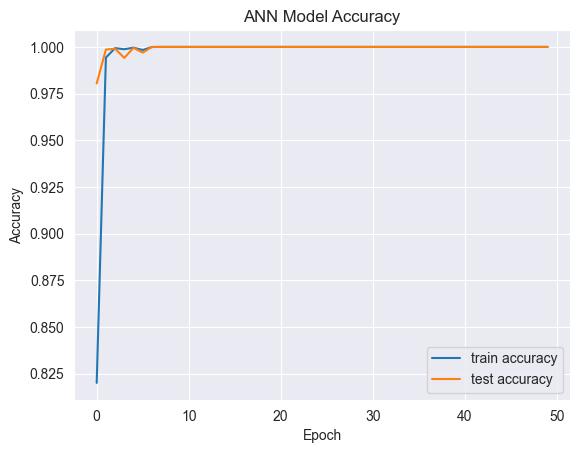

In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import classification_report, accuracy_score
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv('demographics_csv/balanced_age.csv')

# Separate features and target
X = df.drop(columns=[col for col in df.columns if col.startswith('AGE_CLASS_')])
y = df[[col for col in df.columns if col.startswith('AGE_CLASS_')]].idxmax(axis=1).apply(lambda x: int(x.split('_')[-1]))

# Encode any categorical variables
label_encoder = LabelEncoder()
for column in X.select_dtypes(include=['object']).columns:
    X[column] = label_encoder.fit_transform(X[column])

# One-hot encode the target variable for ANN
encoder = OneHotEncoder(sparse_output=False)
y_train_encoded = encoder.fit_transform(y_train.values.reshape(-1, 1))
y_test_encoded = encoder.transform(y_test.values.reshape(-1, 1))

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features (standardization)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Build the ANN model
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(y_train_encoded.shape[1], activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train_encoded, epochs=50, batch_size=32, validation_data=(X_test, y_test_encoded))

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test_encoded)
print("ANN Accuracy: ", test_acc)

# Plotting training & validation accuracy
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='test accuracy')
plt.title('ANN Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()